In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# retrieving data and putting into pandas dataframe
c_cites = pd.read_csv(
    '../data/cora.cites.csv',
    # sep="\t",
    # header=None,
    names=["target", "source"],
    ) # no column unique
c_cites = c_cites.drop(0)
c_cites['target'] = c_cites['target'].apply(pd.to_numeric)
c_cites['source'] = c_cites['source'].apply(pd.to_numeric)
print(c_cites.head())
print(c_cites.shape)
column_names = ["paper_id"] + ["subject"] + [f"word{idx}" for idx in range(1,1434)]
c_paper = pd.read_csv(
    '../data/cora.papers.csv',
    # sep="\t",
    # header=None,
    names=column_names,
    ) # unique paper id
c_paper = c_paper.drop(0) # csv header is automatically formatted to the first row when setting custom column names, so remove
c_paper['paper_id'] = c_paper['paper_id'].apply(pd.to_numeric) # data is not automatically the same data type, so fix
c_paper = c_paper.set_index('paper_id') # set index as paper_id for easier data formatting; can change back later
print(c_paper.head())
print(c_paper.shape)
c_content = pd.read_csv(
    '../data/cora.content.csv',
    # sep="\t",
    # header=None
    ) # no column unique
print(c_content.head())
print(c_content.shape)

   target  source
1      35     887
2      35    1033
3      35    1688
4      35    1956
5      35    8865
(5429, 2)
                         subject  word1  word2  word3  word4  word5  word6  \
paper_id                                                                     
35            Genetic_Algorithms    NaN    NaN    NaN    NaN    NaN    NaN   
40            Genetic_Algorithms    NaN    NaN    NaN    NaN    NaN    NaN   
114       Reinforcement_Learning    NaN    NaN    NaN    NaN    NaN    NaN   
117       Reinforcement_Learning    NaN    NaN    NaN    NaN    NaN    NaN   
128       Reinforcement_Learning    NaN    NaN    NaN    NaN    NaN    NaN   

          word7  word8  word9  ...  word1424  word1425  word1426  word1427  \
paper_id                       ...                                           
35          NaN    NaN    NaN  ...       NaN       NaN       NaN       NaN   
40          NaN    NaN    NaN  ...       NaN       NaN       NaN       NaN   
114         NaN    NaN 

c:\Users\reece\miniconda3\envs\tensorflow_cpu\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
for i in range(1, 1434): # initialize all word columns to zero - manual one hot encoding
    name = "word"+str(i)
    c_paper[name] = 0
for index, row in c_content.iterrows(): # mark as true for words used by each paper
    c_paper.at[int(row['paper_id']), str(row['word_cited_id'])] = 1
c_paper = c_paper.reset_index()
print(c_paper.shape)
print(c_paper.sample(5))

(2708, 1435)
      paper_id                subject  word1  word2  word3  word4  word5  \
2612   1152569     Genetic_Algorithms      0      0      0      0      0   
99        5075             Case_Based      0      0      0      0      1   
2494   1131828             Case_Based      0      0      0      0      0   
1956   1104647     Genetic_Algorithms      0      0      0      0      0   
2438   1131164  Probabilistic_Methods      0      0      0      0      0   

      word6  word7  word8  ...  word1424  word1425  word1426  word1427  \
2612      0      0      0  ...         0         0         1         0   
99        0      0      0  ...         0         0         1         0   
2494      0      0      0  ...         0         0         0         0   
1956      0      0      0  ...         0         0         0         0   
2438      0      0      0  ...         0         0         0         0   

      word1428  word1429  word1430  word1431  word1432  word1433  
2612         0    

In [4]:
class_values = sorted(c_paper["subject"].unique()) # one hot encoding of rest of variables
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(c_paper["paper_id"].unique()))}

c_paper["paper_id"] = c_paper["paper_id"].apply(lambda name: paper_idx[name])
c_cites["source"] = c_cites["source"].apply(lambda name: paper_idx[name])
c_cites["target"] = c_cites["target"].apply(lambda name: paper_idx[name])
c_paper["subject"] = c_paper["subject"].apply(lambda value: class_idx[value])


In [8]:
print(colors)

[1, 1, 4, 4, 4, 4, 6, 4, 5, 4, 0, 3, 3, 1, 2, 2, 0, 0, 0, 0, 1, 1, 1, 4, 5, 2, 4, 6, 2, 2, 0, 1, 1, 3, 5, 1, 3, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 5, 6, 6, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 3, 3, 3, 6, 5, 2, 0, 6, 2, 6, 6, 3, 3, 6, 3, 6, 6, 0, 0, 0, 3, 3, 3, 5, 4, 6, 5, 6, 6, 0, 1, 6, 6, 0, 0, 0, 0, 3, 2, 2, 2, 2, 0, 2, 0, 1, 6, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 0, 0, 0, 0, 0, 4, 4, 6, 5, 6, 0, 6, 2, 6, 2, 3, 3, 3, 2, 2, 3, 5, 5, 2, 5, 5, 5, 2, 3, 2, 4, 2, 2, 2, 2, 4, 4, 4, 2, 2, 0, 6, 4, 6, 2, 5, 5, 2, 2, 5, 6, 6, 5, 5, 0, 0, 1, 4, 1, 1, 4, 6, 6, 5, 3, 1, 0, 6, 6, 6, 6, 0, 6, 0, 0, 2, 6, 0, 0, 2, 3, 5, 5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 6, 2, 2, 1, 1, 2, 2, 3, 6, 5, 2, 4, 4, 4, 4, 2, 4, 3, 2, 2, 2, 2, 2, 5, 2, 4, 4, 4, 4, 6, 1, 2, 3, 3, 3, 3, 3, 0, 0, 2, 6, 6, 2, 6, 6, 1, 0, 0, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 3, 2, 4, 1, 4, 0, 1, 4, 0, 4, 2, 2, 1, 5, 6, 3, 3, 3, 3, 6, 3, 3, 3, 0, 4, 4, 4, 1, 6, 2, 2, 0, 0, 0, 

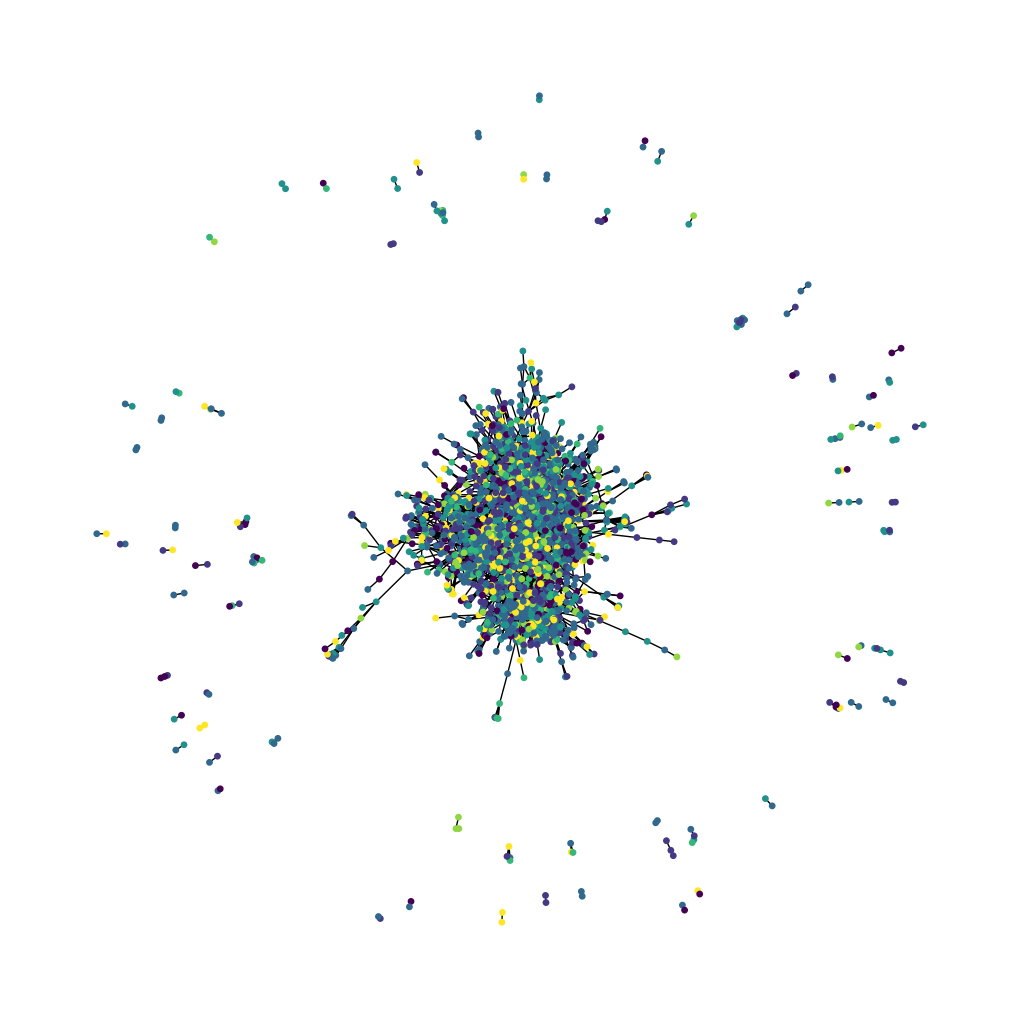

In [5]:
plt.figure(figsize=(10, 10))
colors = c_paper["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(c_cites)#.sample(n=1500))
subjects = list(c_paper[c_paper["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [7]:
print(cora_graph)

Graph with 2708 nodes and 5278 edges


In [21]:
train_data, test_data = [], []

for _, group_data in c_paper.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (2149, 1435)
Test data shape: (559, 1435)


In [22]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [45]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="lower right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)



In [25]:
feature_names = set(c_paper.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]


In [28]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()


Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [29]:
history = run_experiment(baseline_model, x_train, y_train)


Epoch 1/300
8/8 [==============================] - 6s 108ms/step - loss: 3.6106 - acc: 0.1736 - val_loss: 1.9880 - val_acc: 0.1207
Epoch 2/300
8/8 [==============================] - 0s 25ms/step - loss: 2.4785 - acc: 0.2530 - val_loss: 1.9376 - val_acc: 0.1238
Epoch 3/300
8/8 [==============================] - 0s 25ms/step - loss: 2.0957 - acc: 0.2623 - val_loss: 1.9330 - val_acc: 0.1517
Epoch 4/300
8/8 [==============================] - 0s 25ms/step - loss: 1.9037 - acc: 0.2568 - val_loss: 1.8987 - val_acc: 0.2539
Epoch 5/300
8/8 [==============================] - 0s 26ms/step - loss: 1.7909 - acc: 0.3341 - val_loss: 1.8469 - val_acc: 0.3127
Epoch 6/300
8/8 [==============================] - 0s 26ms/step - loss: 1.7187 - acc: 0.3423 - val_loss: 1.8038 - val_acc: 0.4241
Epoch 7/300
8/8 [==============================] - 0s 26ms/step - loss: 1.6795 - acc: 0.3806 - val_loss: 1.7671 - val_acc: 0.5418
Epoch 8/300
8/8 [==============================] - 0s 27ms/step - loss: 1.5674 - acc: 0.4

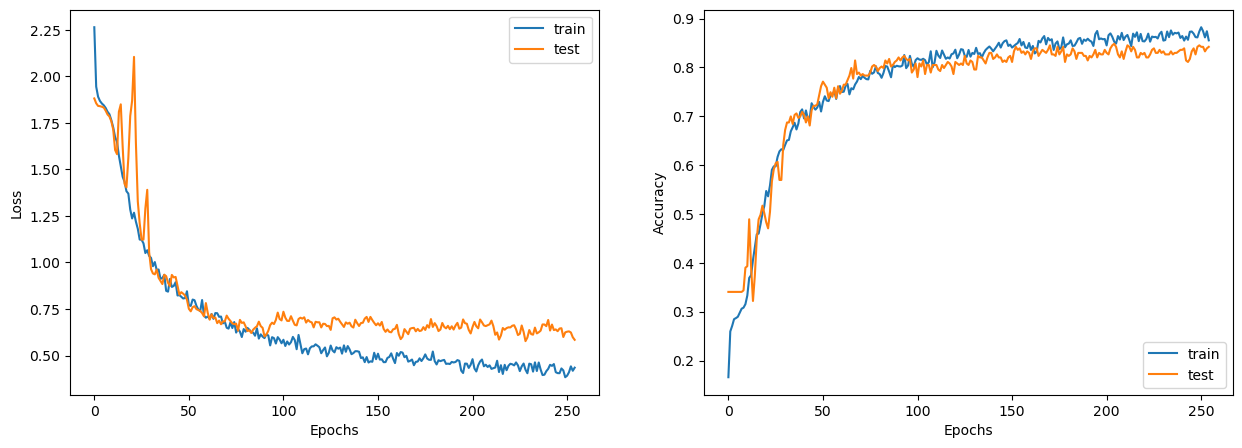

In [46]:
display_learning_curves(history)


In [31]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")


Test accuracy: 79.43%


In [32]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


In [33]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)


1/1 [==============================] - 1s 555ms/step
Instance 1:
- Case_Based: 1.61%
- Genetic_Algorithms: 71.89%
- Neural_Networks: 14.0%
- Probabilistic_Methods: 1.81%
- Reinforcement_Learning: 3.39%
- Rule_Learning: 0.82%
- Theory: 6.48%
Instance 2:
- Case_Based: 3.26%
- Genetic_Algorithms: 46.71%
- Neural_Networks: 19.42%
- Probabilistic_Methods: 2.43%
- Reinforcement_Learning: 20.89%
- Rule_Learning: 1.44%
- Theory: 5.85%
Instance 3:
- Case_Based: 4.58%
- Genetic_Algorithms: 21.2%
- Neural_Networks: 30.38%
- Probabilistic_Methods: 6.86%
- Reinforcement_Learning: 1.77%
- Rule_Learning: 1.35%
- Theory: 33.87%
Instance 4:
- Case_Based: 2.59%
- Genetic_Algorithms: 7.99%
- Neural_Networks: 19.12%
- Probabilistic_Methods: 43.85%
- Reinforcement_Learning: 3.97%
- Rule_Learning: 1.57%
- Theory: 20.91%
Instance 5:
- Case_Based: 0.12%
- Genetic_Algorithms: 13.44%
- Neural_Networks: 67.67%
- Probabilistic_Methods: 1.62%
- Reinforcement_Learning: 4.21%
- Rule_Learning: 0.07%
- Theory: 12.87%


In [35]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = c_cites[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    c_paper.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)


Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [36]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [37]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [38]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()


GNN output shape: tf.Tensor(
[[-0.04801464 -0.02449707  0.10732485  0.08223633  0.10019511 -0.03937722
   0.08002994]
 [-0.05053116  0.03103667  0.04737559  0.03187552 -0.01161938 -0.00172772
   0.01771168]
 [-0.06227836 -0.08557606  0.00756196 -0.00983644 -0.00255059  0.13234486
   0.1225025 ]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                            

In [39]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)


Epoch 1/300
8/8 [==============================] - 8s 246ms/step - loss: 2.2636 - acc: 0.1659 - val_loss: 1.8810 - val_acc: 0.3406
Epoch 2/300
8/8 [==============================] - 1s 128ms/step - loss: 1.9444 - acc: 0.2596 - val_loss: 1.8550 - val_acc: 0.3406
Epoch 3/300
8/8 [==============================] - 1s 132ms/step - loss: 1.8904 - acc: 0.2711 - val_loss: 1.8410 - val_acc: 0.3406
Epoch 4/300
8/8 [==============================] - 1s 141ms/step - loss: 1.8675 - acc: 0.2848 - val_loss: 1.8395 - val_acc: 0.3406
Epoch 5/300
8/8 [==============================] - 1s 134ms/step - loss: 1.8540 - acc: 0.2870 - val_loss: 1.8366 - val_acc: 0.3406
Epoch 6/300
8/8 [==============================] - 1s 131ms/step - loss: 1.8444 - acc: 0.2897 - val_loss: 1.8320 - val_acc: 0.3406
Epoch 7/300
8/8 [==============================] - 1s 147ms/step - loss: 1.8302 - acc: 0.2979 - val_loss: 1.8156 - val_acc: 0.3406
Epoch 8/300
8/8 [==============================] - 1s 133ms/step - loss: 1.8097 - a

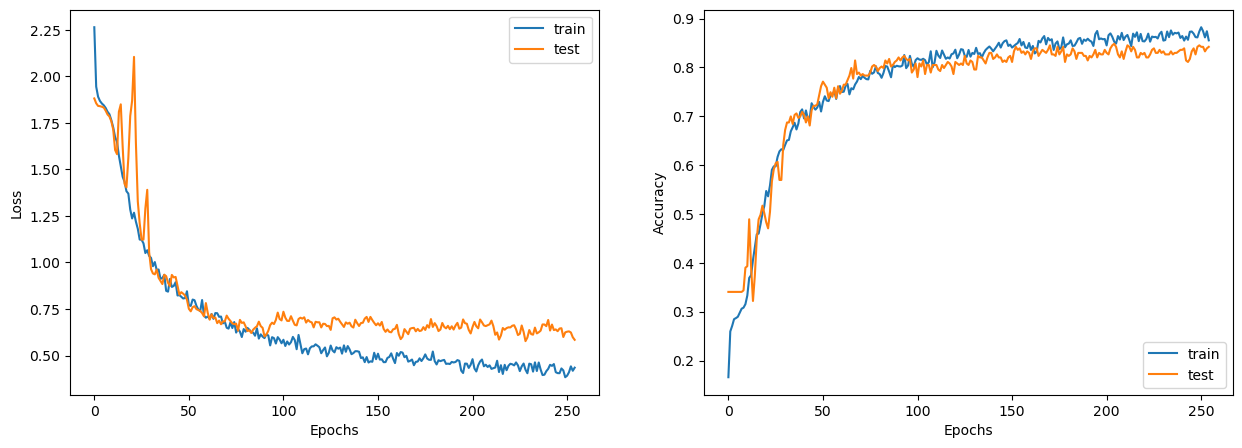

In [47]:
display_learning_curves(history)

In [40]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")


Test accuracy: 86.58%


In [42]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in c_paper.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(c_paper.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)


In [43]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)


Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 [==============================] - 2s 2s/step
Instance 1:
- Case_Based: 10.37%
- Genetic_Algorithms: 10.74%
- Neural_Networks: 6.43%
- Probabilistic_Methods: 2.03%
- Reinforcement_Learning: 5.31%
- Rule_Learning: 50.63%
- Theory: 14.48%
Instance 2:
- Case_Based: 0.07%
- Genetic_Algorithms: 47.72%
- Neural_Networks: 49.48%
- Probabilistic_Methods: 0.09%
- Reinforcement_Learning: 2.43%
- Rule_Learning: 0.04%
- Theory: 0.17%
Instance 3:
- Case_Based: 0.18%
- Genetic_Algorithms: 0.27%
- Neural_Networks: 97.48%
- Probabilistic_Methods: 1.12%
- Reinforcement_Learning: 0.32%
- Rule_Learning: 0.1%
- Theory: 0.54%
Instance 4:
- Case_Based: 0.0%
- Genetic_Algorithms: 0.0%
- Neural_Networks: 0.41%
- Probabilistic_Methods: 99.54%
- Reinforcement_Learning: 0.0%
- Rule_Learning: 0.0%
- Theory: 0.05%
Instance 5:
- Case_Based: 0.1%
- Genetic_Algorithms: 98.16%